In [24]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fab = pd.read_csv('final_ab_ds.csv')

fab.head()

,Unnamed: 0,person_id,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,pneumonia,ihd,dm,ah,sex,len,age,GFR,ab_indication
0,933614,939,0.188605,NaN,0.841533,17.599582,129.193417,308.862607,64.781725,26.713692,3.318568,1,0,0,0,1,35,60,75.618846,0
1,3822,158,0.000000,8.909846,1.030282,1.363834,143.647123,644.437365,58.343027,34.424705,23.300684,1,0,0,0,1,17,56,60.894798,0
2,915492,342,0.000000,7.092240,1.027174,25.710224,130.864644,483.261016,0.800000,25.493102,27.004637,1,0,0,0,1,34,56,61.117621,0
3,641908,108,0.134918,13.265546,0.707201,0.410000,141.945473,477.671705,7.526411,46.599795,17.167563,1,0,0,0,1,26,56,95.972393,0
4,89879,108,0.000000,15.336425,1.094880,12.546527,120.607466,704.633325,27.180197,35.411333,15.268175,1,0,0,0,1,28,56,56.578279,0


In [4]:
fab = fab.dropna()

fab['ab_indication'].value_counts()

0    26807
1     8873
Name: ab_indication, dtype: int64

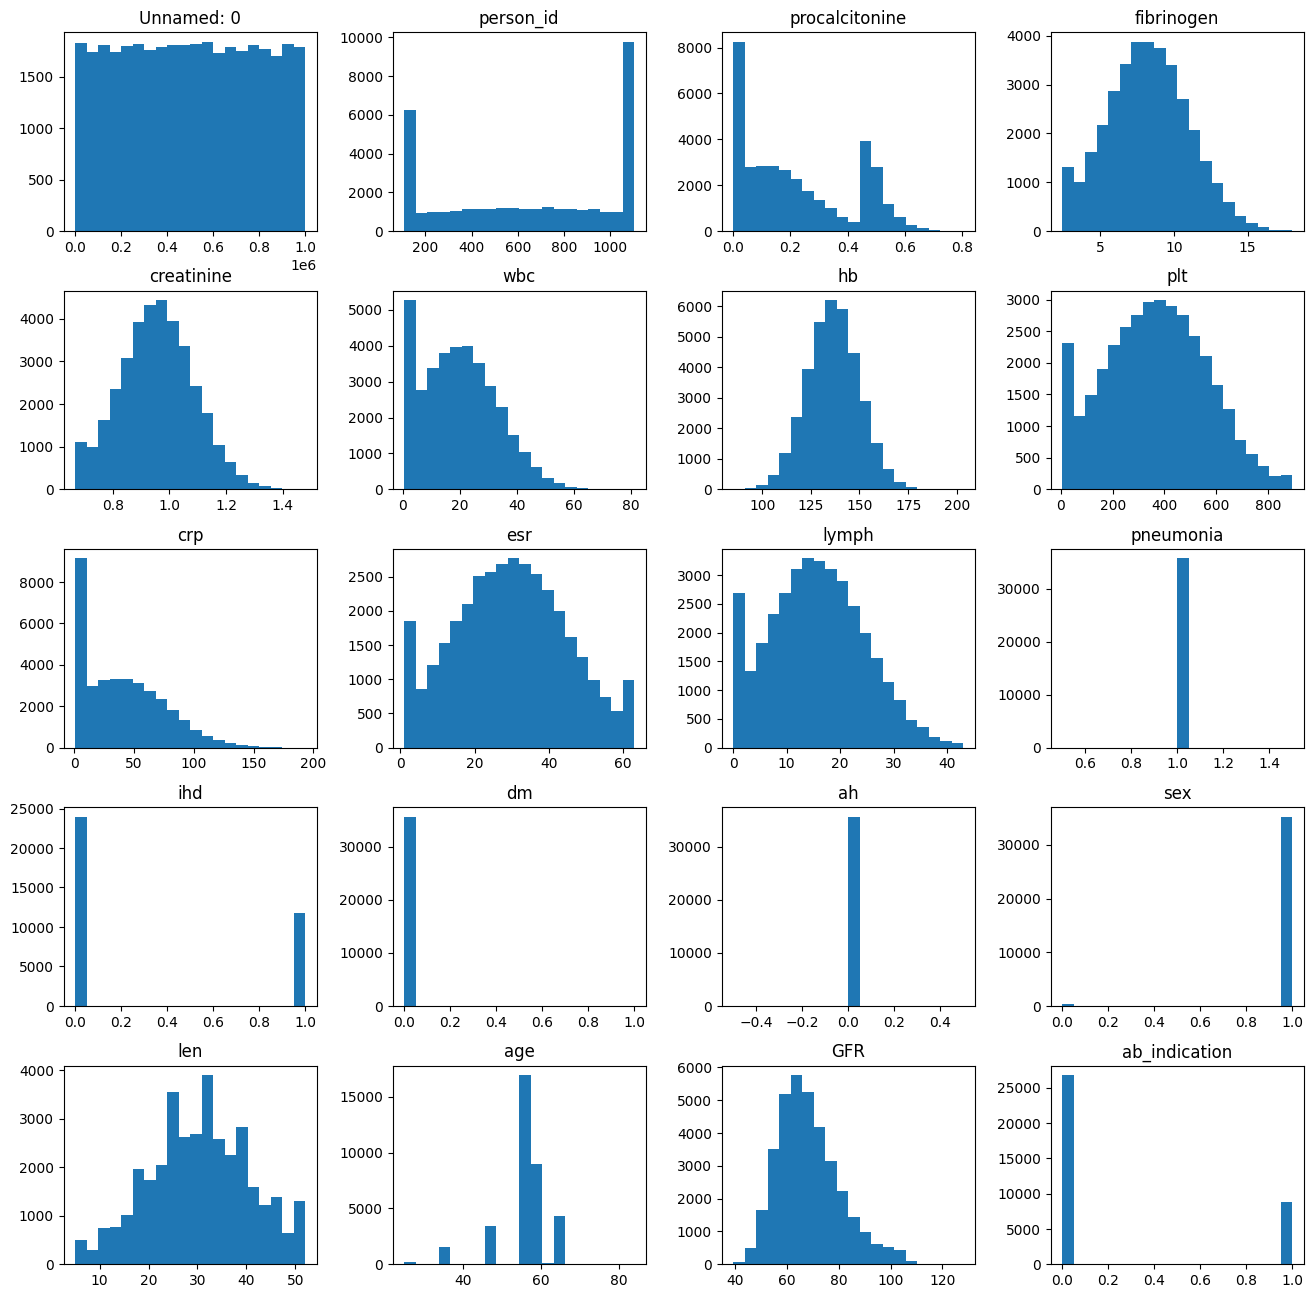

In [5]:
fab.hist(figsize=(16, 16), bins=20, grid=False);

Одинаковые значение по пневмонии (есть у всех), dm, ah. Непонятно что за столбец Unnamed:0 <br>
Всех их наряду с person id (не важны для модели, могут только запутать) можно убрать

In [6]:
cols = ['procalcitonine',
         'fibrinogen',
         'creatinine',
         'wbc',
         'hb',
         'plt',
         'crp',
         'esr',
         'lymph',
         'ihd',
         'sex',
         'len',
         'age',
         'GFR',
         'ab_indication']

df = fab[cols]
df.head()

,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,ihd,sex,len,age,GFR,ab_indication
1,0.000000,8.909846,1.030282,1.363834,143.647123,644.437365,58.343027,34.424705,23.300684,0,1,17,56,60.894798,0
2,0.000000,7.092240,1.027174,25.710224,130.864644,483.261016,0.800000,25.493102,27.004637,0,1,34,56,61.117621,0
3,0.134918,13.265546,0.707201,0.410000,141.945473,477.671705,7.526411,46.599795,17.167563,0,1,26,56,95.972393,0
4,0.000000,15.336425,1.094880,12.546527,120.607466,704.633325,27.180197,35.411333,15.268175,0,1,28,56,56.578279,0
5,0.324985,9.899282,1.265045,7.001120,125.988145,166.613698,0.800000,27.280940,12.404405,1,1,33,48,50.257856,0


In [7]:
# Корректируем выбросные значения

df = df[df['plt'] > 15]
df = df[df['lymph'] > 1]
df = df[df['fibrinogen'] != 0]

In [8]:
# Выделение целевой переменной и групп признаков

TARGET_NAME = 'ab_indication'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

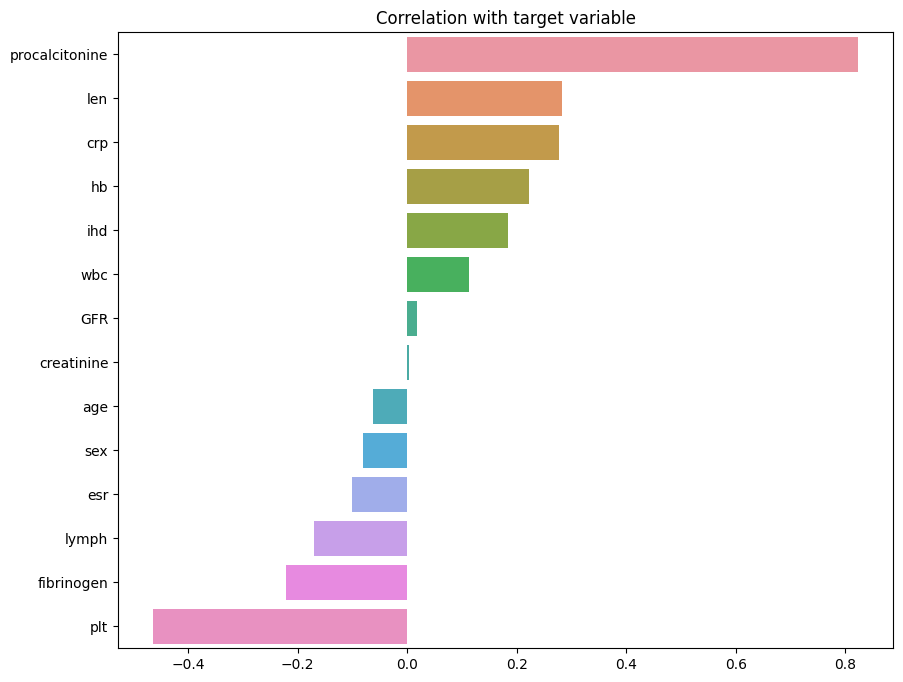

In [9]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Прямая корреляция с прокальцитонином и обратная с уровнем тромбоцитов > фибриногена > лимфоцитов

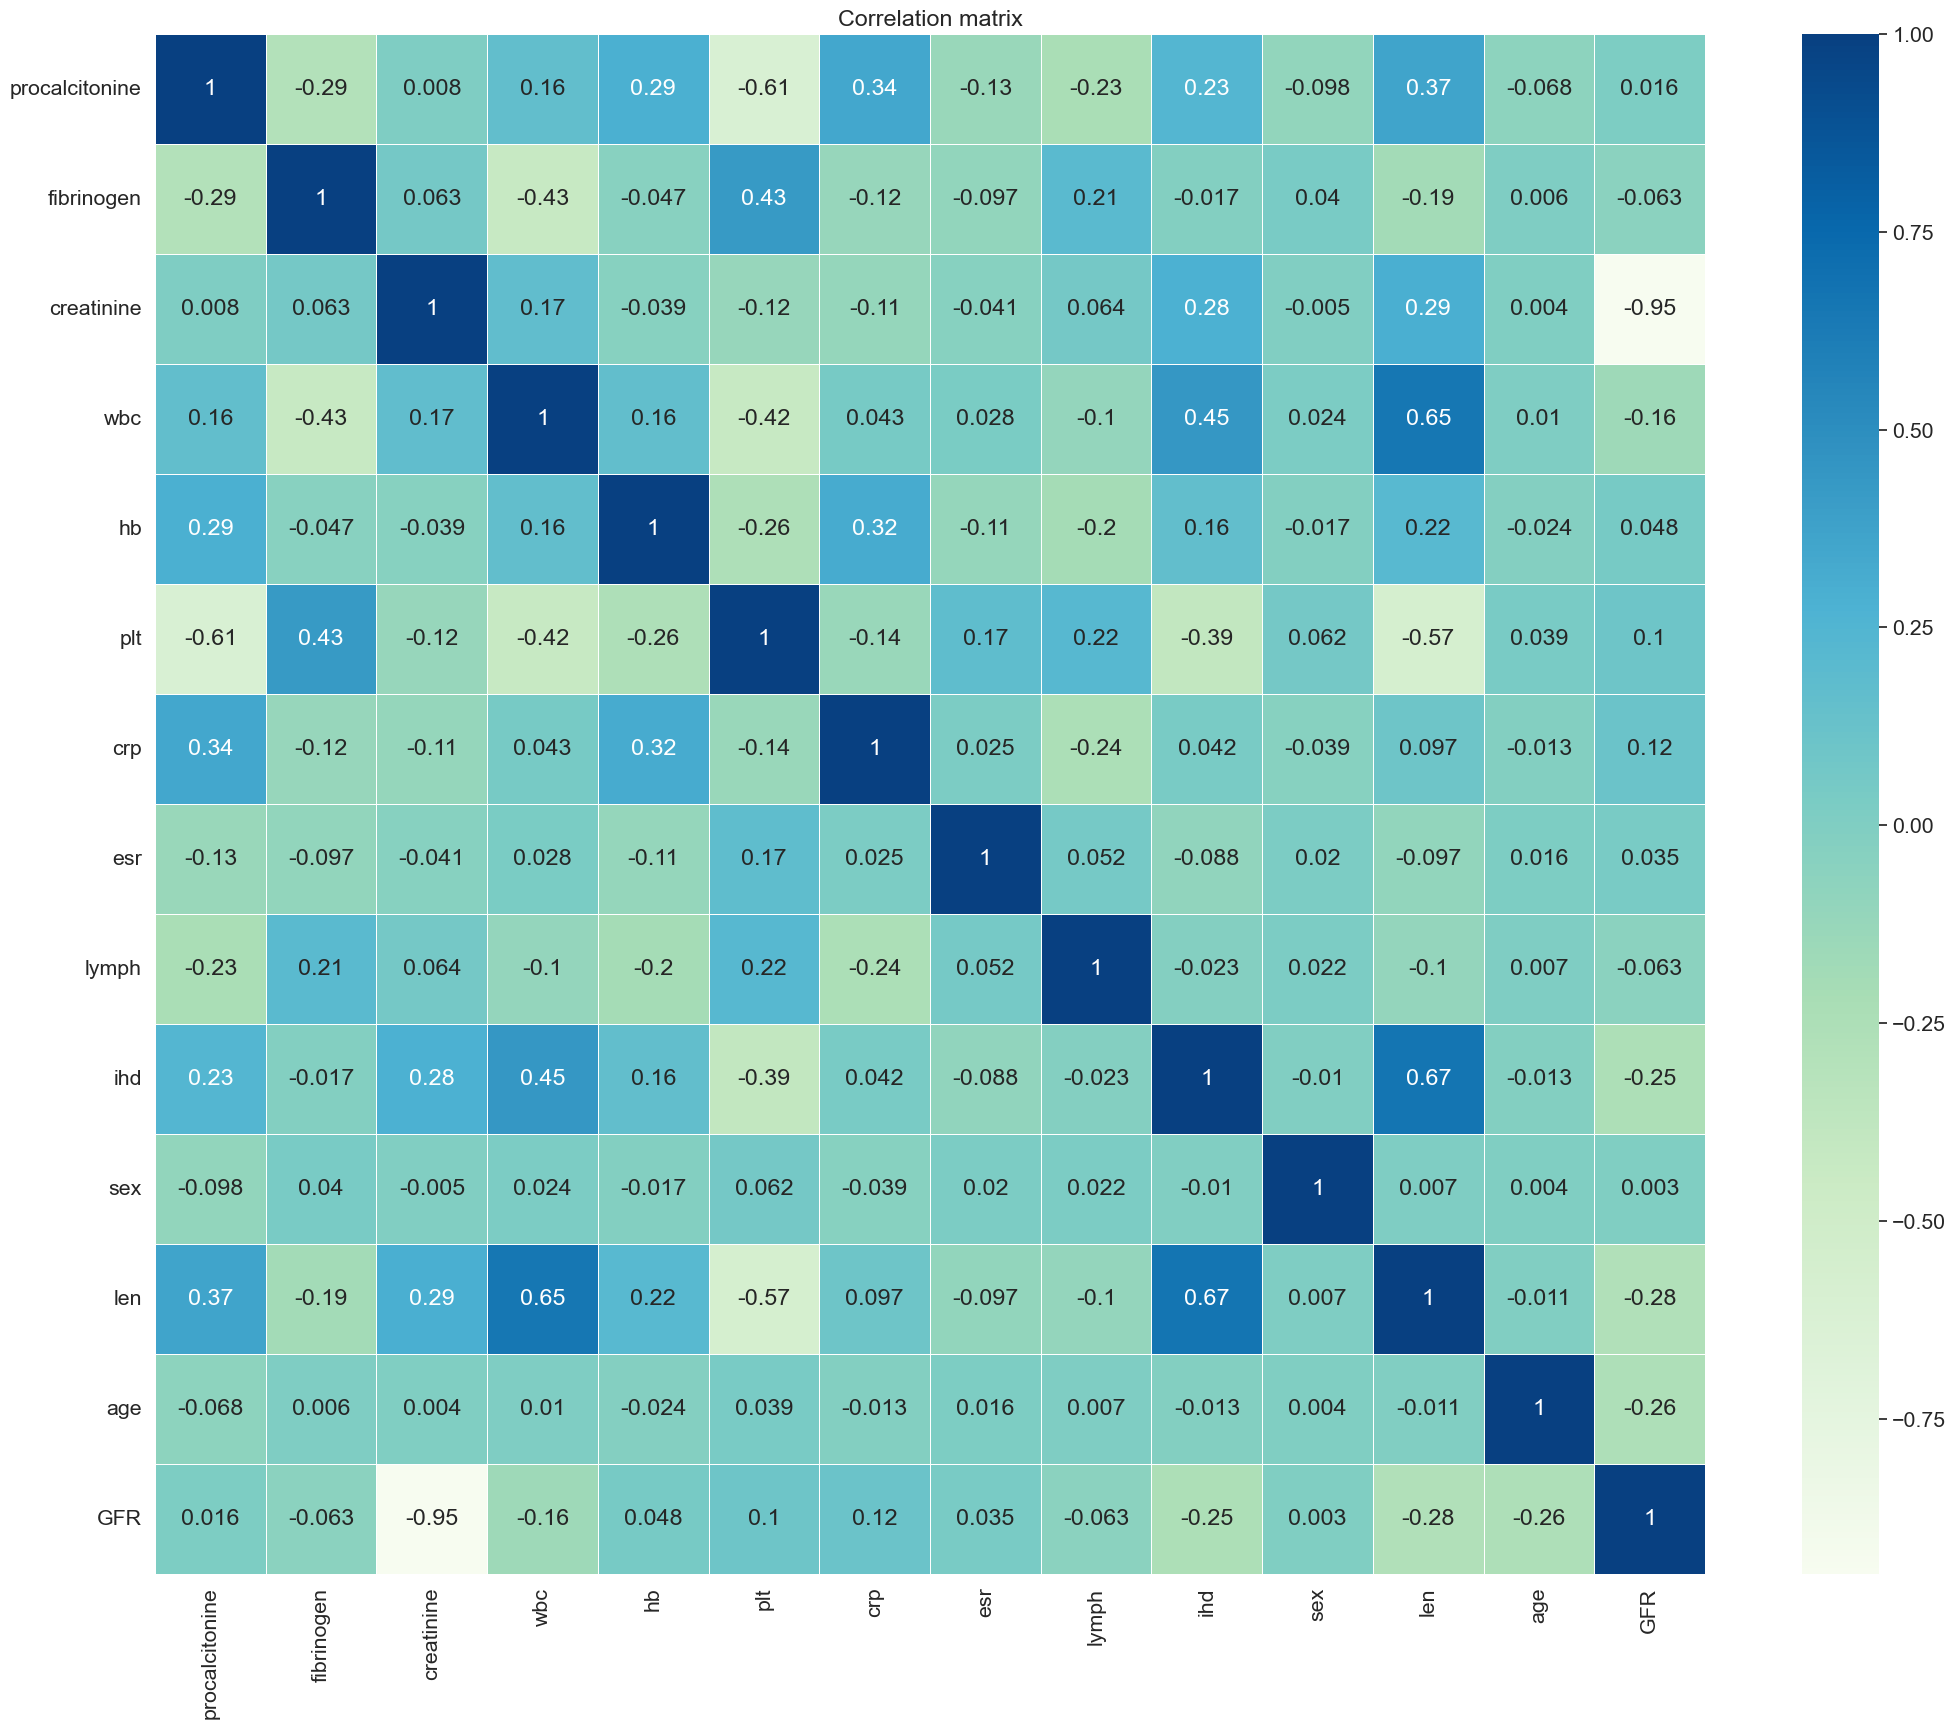

In [10]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [11]:
NUM_FEATURE_NAMES = ['procalcitonine', 'fibrinogen', 'creatinine', 'wbc', 'hb', 'plt',
                     'crp', 'len', 'age', 'esr', 'lymph']

CAT_FEATURE_NAMES = ['ihd', 'sex']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

In [12]:
X = df.drop(columns=TARGET_NAME)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

In [13]:
# для выравнивания по целевому признаку (несбалансированное распределение)
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [14]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    17851
1    13998
Name: ab_indication, dtype: int64

In [15]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [16]:
# прописываем функцию для получения репорта
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Объяснение почему именно такая модель: задача классификации, есть возможность дополнительно вбить в модель категориальные признаки

In [17]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17851
           1       1.00      1.00      1.00     13998

    accuracy                           1.00     31849
   macro avg       1.00      1.00      1.00     31849
weighted avg       1.00      1.00      1.00     31849

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7597
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      9651
   macro avg       1.00      1.00      1.00      9651
weighted avg       1.00      1.00      1.00      9651

CONFUSION MATRIX

col_0             0     1
ab_indication            
0              7594     3
1                 3  2051


In [19]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 1.3], silent=True, random_state=21, cat_features=CAT_FEATURE_NAMES)

In [22]:
params = {'n_estimators':[50, 100, 200, 500, 700],
          'max_depth':[3, 5, 7]}
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [25]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: total: 7.39 s
Wall time: 31 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000021A1351EA40>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500,
                                                         700]},
                   scoring='f1')

In [26]:
rs.best_params_

{'n_estimators': 700, 'max_depth': 5}

In [27]:
rs.best_score_

0.998661311914324

In [28]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5,
                                      silent=True, random_state=21,
                                      cat_features=CAT_FEATURE_NAMES)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17851
           1       1.00      1.00      1.00     13998

    accuracy                           1.00     31849
   macro avg       1.00      1.00      1.00     31849
weighted avg       1.00      1.00      1.00     31849

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7597
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      9651
   macro avg       1.00      1.00      1.00      9651
weighted avg       1.00      1.00      1.00      9651

CONFUSION MATRIX

col_0             0     1
ab_indication            
0              7594     3
1                 2  2052


In [29]:
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)

get_classification_report(y_train, y_train_pred, y_val, y_val_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17851
           1       1.00      1.00      1.00     13998

    accuracy                           1.00     31849
   macro avg       1.00      1.00      1.00     31849
weighted avg       1.00      1.00      1.00     31849

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7597
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      9651
   macro avg       1.00      1.00      1.00      9651
weighted avg       1.00      1.00      1.00      9651

CONFUSION MATRIX

col_0             0     1
ab_indication            
0              7594     3
1                 2  2052
